# About

This notebook illustrates XES generation algorithm.

Algoritma galima padalinti i 3 zingsnius, kurie yra vykdomi nuosekliai:

1. Ivykiu strukturos generavimas
2. Ivykiu laiku generavimas
3. Atributu generavimas

Toliau bus pateiktos kiekvienos dalies aprasymas. Siame dokumente bus naudojamas pavyzdynis ivykiu zurnalas "simple.xes".

In [1]:
%load_ext autoreload
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
# %matplotlib ipympl

In [2]:
%autoreload
import maxes.notebooks.utils
import maxes.utils

Config:
{'project_directory_path': '/vt/md/maxes/maxes', 'data_directory_path': '/vt/md/maxes/maxes/data'}


In [3]:
maxes.notebooks.utils.init_notebook()

Loading config from: C:\vt\md\maxes\maxes\config.local.yml
Config:
{'project_directory_path': '/vt/md/maxes/maxes', 'data_directory_path': '/vt/md/maxes/maxes/data'}


Skaitome zurnala is failo ir atvaizduojame zurnalo pirma trace'a, kad susipazinti:

In [4]:
file_path = maxes.notebooks.utils.get_data_path("other/simple.xes")
log = maxes.notebooks.utils.load_xes(file_path)

df = log.traces[0].df
df.reindex(["concept:name", "lifecycle:transition", "time:timestamp", "org:resource", "call centre", "location", "outcome", "duration"], axis=1)

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome,duration
0,incoming claim,complete,1970-01-01 00:00:00+00:00,customer,Brisbane,NaN,NaN,NaN
1,B check if sufficient information is available,start,1970-01-01 00:00:00+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN,NaN
2,B check if sufficient information is available,complete,1970-01-01 00:00:41+00:00,Call Centre Agent Brisbane,NaN,Brisbane,NaN,NaN
3,B register claim,start,1970-01-01 00:00:41+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN,NaN
4,B register claim,complete,1970-01-01 00:12:59+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN,NaN
5,determine likelihood of claim,start,1970-01-01 00:47:04+00:00,Claims handler,NaN,NaN,NaN,NaN
6,determine likelihood of claim,complete,1970-01-01 00:47:12+00:00,Claims handler,NaN,NaN,NaN,NaN
7,end,start,1970-01-01 00:47:12+00:00,Claims handler,NaN,NaN,not liable,2832
8,end,complete,1970-01-01 00:47:12+00:00,Claims handler,NaN,NaN,not liable,2832


# 1. Ivykiu strukturos generavimas

Pirmas zingsinis yra sugeneruoti struktura.

Pradziai, paimkime supaprastinta sio zurnalo atitikmeni. Pabandykime atlikti eksperimentus su "concept:name", o veliau pridekime ir "lifecycle:transition" atributa.

In [7]:
%autoreload
from maxes.analyze_sequence import analyze_xes_log_sequence

log__simple_filtered = maxes.notebooks.utils.load_xes(file_path)

for trace in log__simple_filtered.traces:
    trace.df = trace.df[trace.df["lifecycle:transition"] == "start"]

log_graph = analyze_xes_log_sequence(log__simple_filtered)

relabel_mapping = {label: label[0] for label in log_graph.nodes}
nx.relabel_nodes(log_graph, relabel_mapping, copy=False)

log__simple_filtered.traces[1].df

,call centre,org:resource,time:timestamp,lifecycle:transition,concept:name,location,duration,outcome
1,NaN,Call Centre Agent Sydney,1970-01-01 00:00:00+00:00,start,S check if sufficient information is available,Sydney,NaN,NaN
3,NaN,Call Centre Agent Sydney,1970-01-01 00:00:21+00:00,start,S register claim,NaN,NaN,NaN
5,NaN,Claims handler,1970-01-01 00:01:54+00:00,start,determine likelihood of claim,NaN,NaN,NaN
7,NaN,Claims handler,1970-01-01 00:02:05+00:00,start,assess claim,NaN,NaN,NaN
9,NaN,Claims handler,1970-01-01 00:04:09+00:00,start,advise claimant on reimbursement,NaN,NaN,NaN
11,NaN,Claims handler,1970-01-01 00:07:58+00:00,start,initiate payment,NaN,NaN,NaN
13,NaN,Claims handler,1970-01-01 00:08:53+00:00,start,close claim,NaN,NaN,NaN
15,NaN,Claims handler,1970-01-01 00:08:54+00:00,start,end,NaN,534,processed


Sis objektas bus naudingas veliau, grafu atvaizdavimui:

In [8]:
pos = {
    'B check if sufficient information is available': [0, 0],
    'B register claim': [0, -1],
    'determine likelihood of claim': [0, -2],
    'S check if sufficient information is available': [2, 0],
    'S register claim': [2, -1],
    'assess claim': [0, -3],
    'advise claimant on reimbursement': [0, -4],
    'initiate payment': [-1, -4],
    'close claim': [0, -5],
    'end': [3, -6],
}

Pirmiausia yra skaiciuojamas bendras ivykiu grafas. Sis grafas gaunamas pereinant kiekviena zurnalo trace:

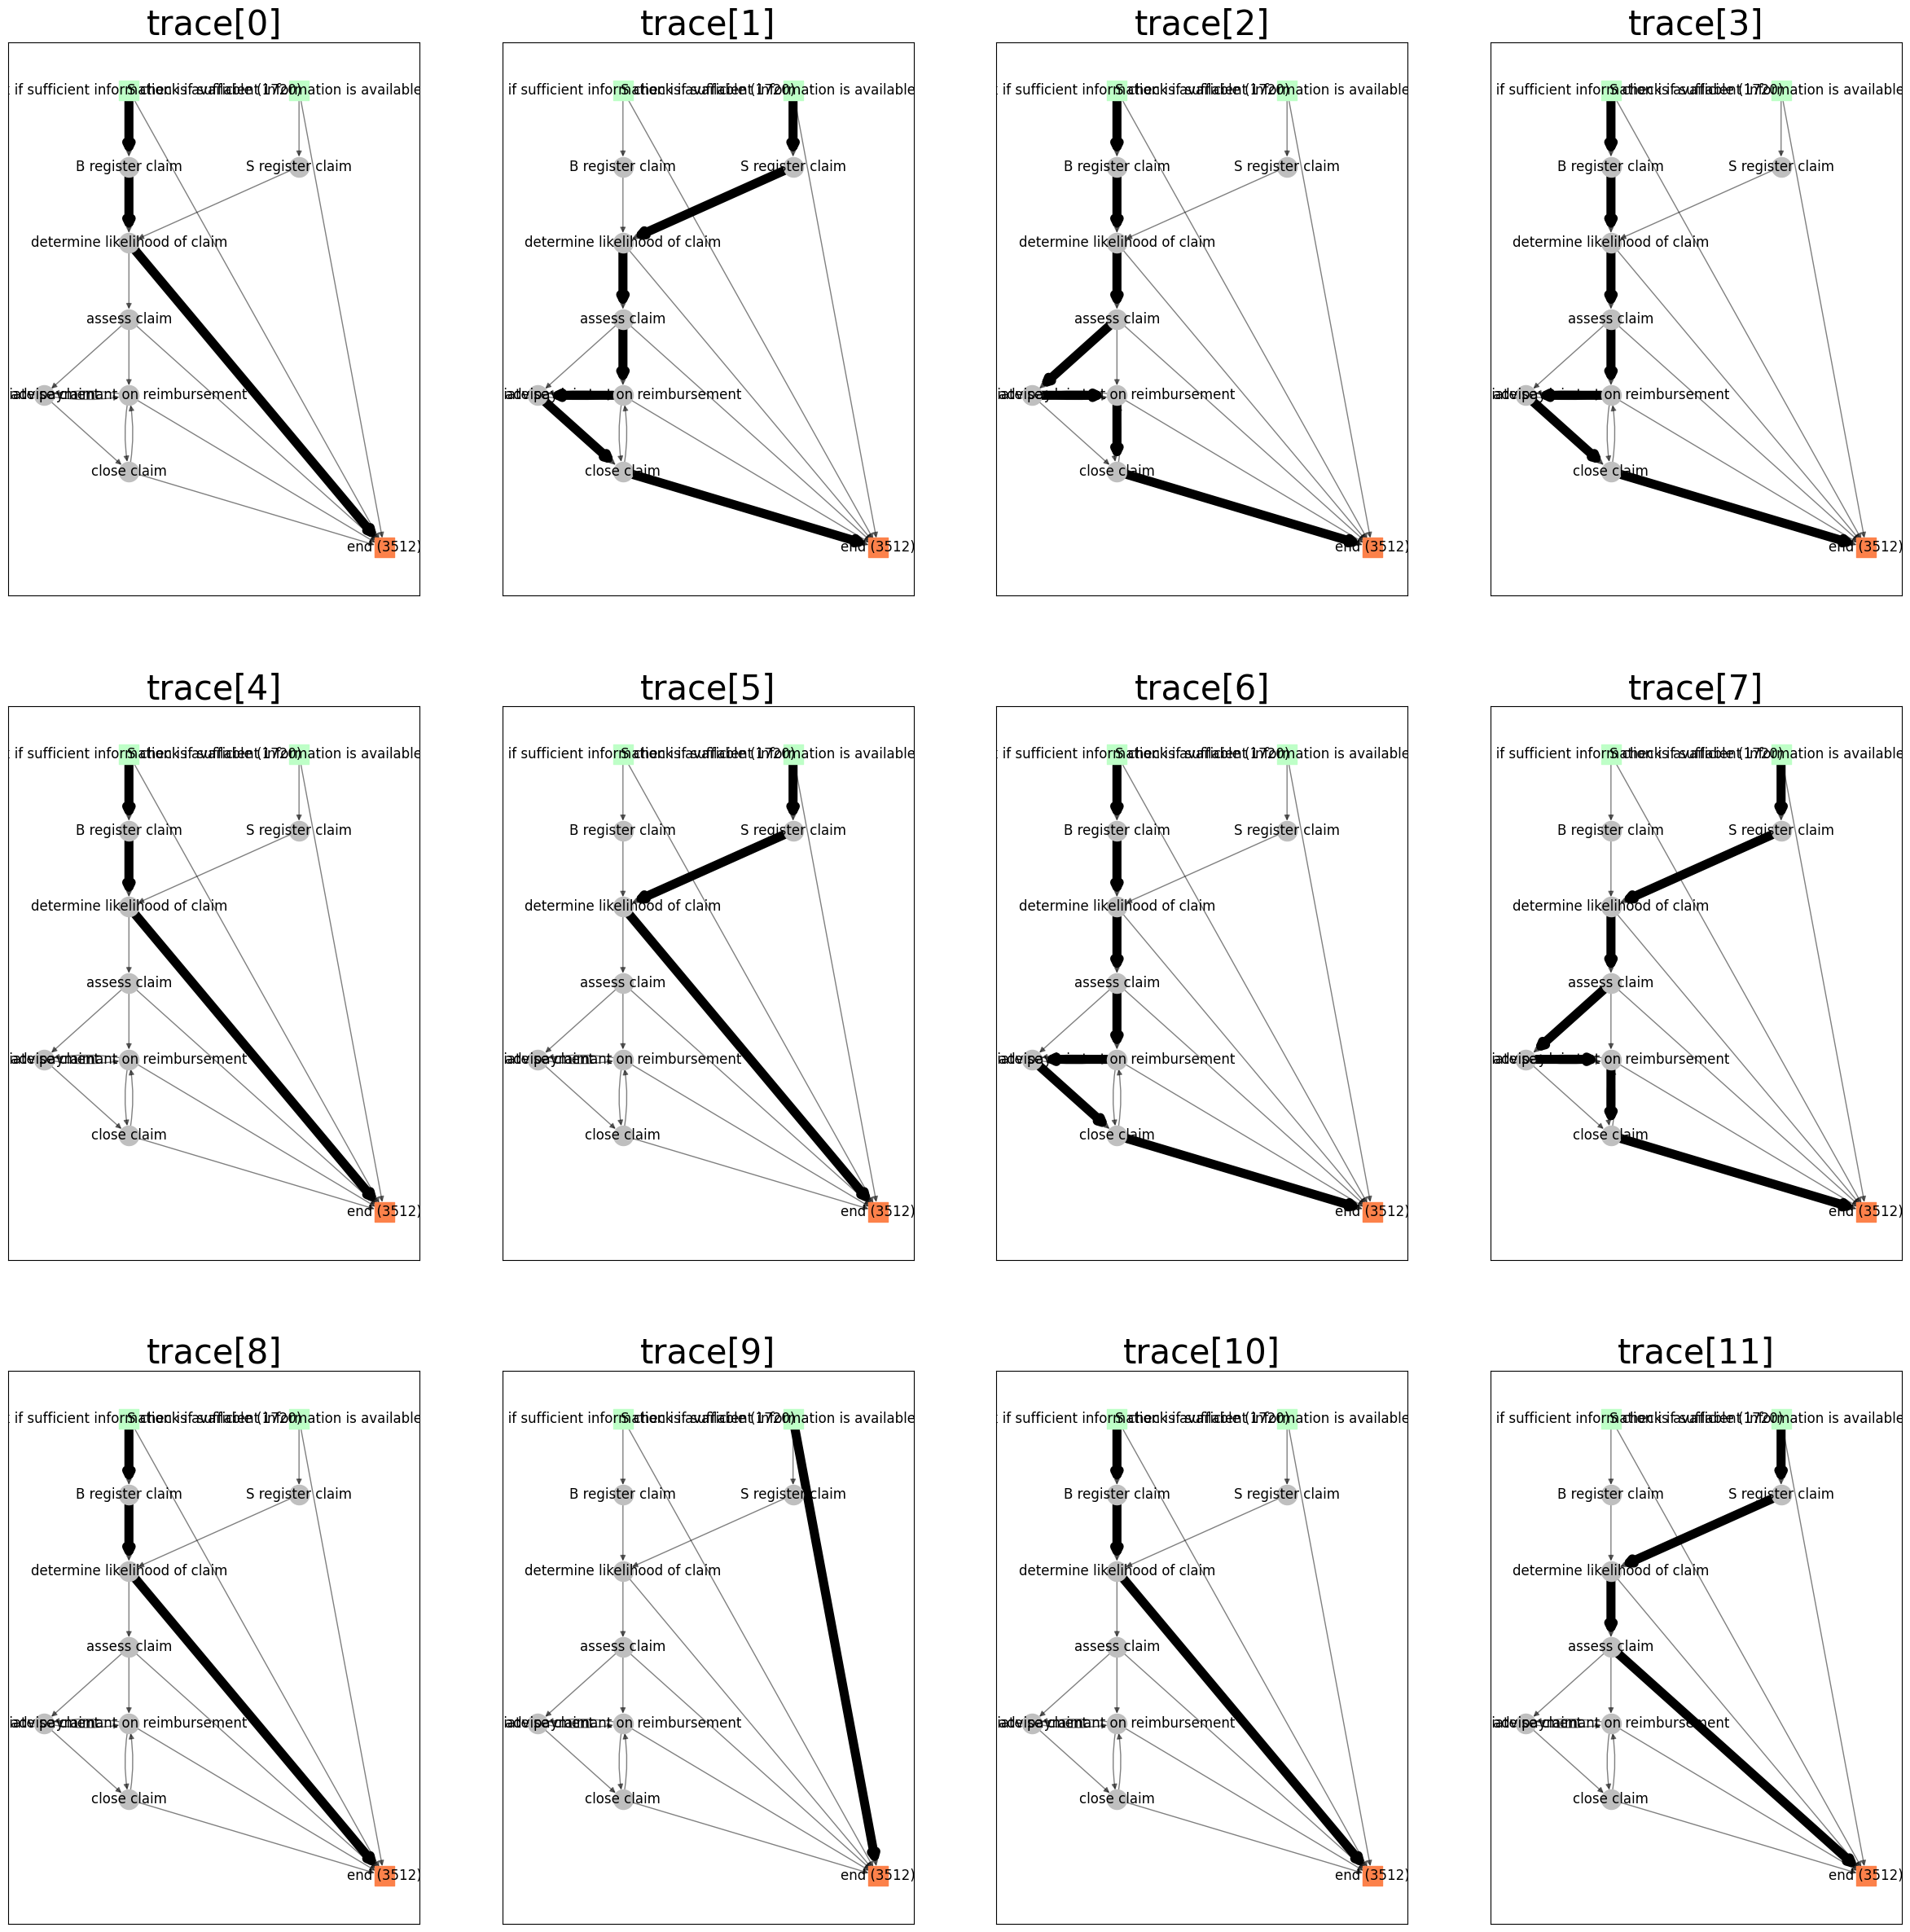

In [9]:
from maxes.analyze_sequence import analyze_xes_trace_sequence

fig, axs = plt.subplots(3, 4)
fig.set_size_inches(30, 30)

for index, ax in enumerate(axs.reshape(-1)):
    trace_graph = analyze_xes_trace_sequence(log__simple_filtered.traces[index].df)
    nx.relabel_nodes(trace_graph, relabel_mapping, copy=False)

    maxes.analyze_sequence.draw_nx_graph(log_graph, ax=ax, pos=pos)

    nx.draw_networkx_edges(trace_graph, ax=ax, pos=pos, width=8)

    ax.set_title(f"trace[{index}]", fontsize=30)

Patogumui, trace'u grafai yra pavaizduoti virs galutinio grafo, nors sitame zingsnyje jis dar nera zinomas.

Sujungus siuos atskirus grafus, i viena, gauname toki vaizda:

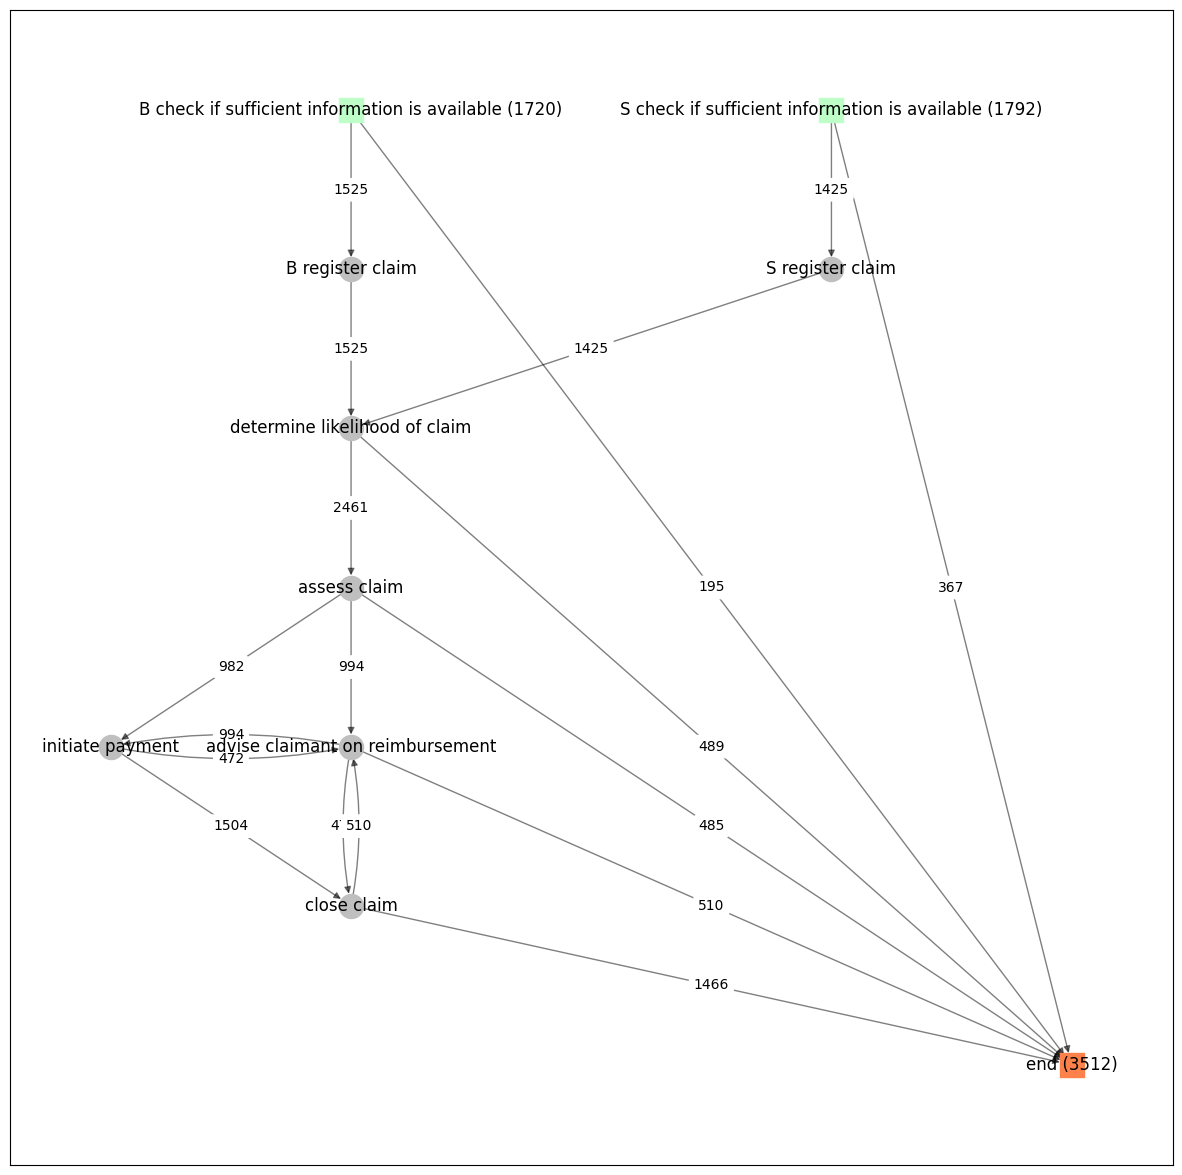

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
maxes.analyze_sequence.draw_nx_graph(log_graph, edge_label="frequency", ax=ax, pos=pos)

Skaiciai prie briaunu parodo, kiek kartu buvo pastebetas perejimas tarp dvieju ivykiu. Sie skaiciai gaunami sujungiant visu trace'u grafus.

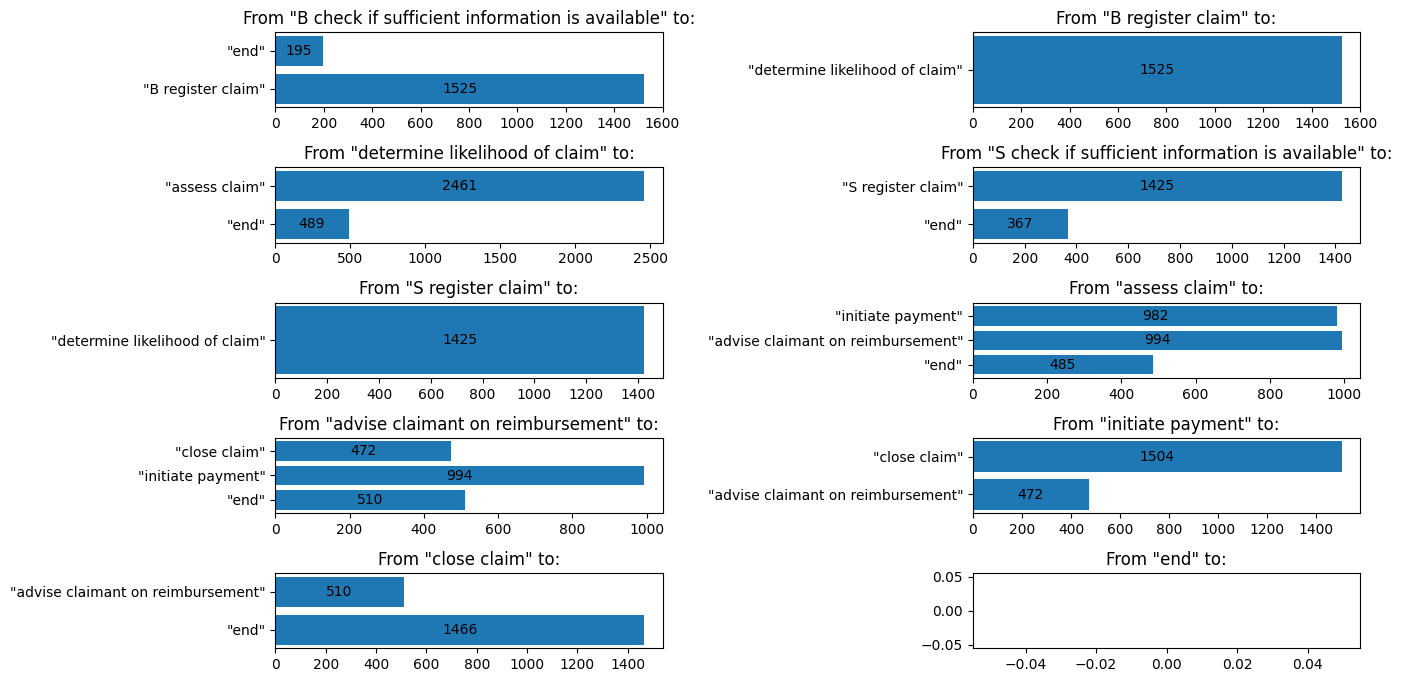

In [11]:
nodes = list(pos.keys())

fig, axs = plt.subplots(5, 2)

fig.subplots_adjust(hspace=0.8, wspace=0.8)
fig.set_size_inches(14, 8)

for index, ax in enumerate(axs.reshape(-1)):
    node = nodes[index]
    data = [(node, data["frequency"]) for node, data in log_graph[node].items()]
    x = ["\"" + i[0] + "\"" for i in data]
    y = [i[1] for i in data]

    p = ax.barh(x, y, label=None)
    ax.bar_label(p, label_type="center")

    ax.set_title(f"From \"{node}\" to:")

Nauja ivykiu struktura gaunama atsitiktinai pereinant per grafo taskus. Kiekvienam perejimui, atsizvelgiama i tai, kiek kart buvo pastebetas perejimas.

In [12]:
import networkx as nx
import itertools
import matplotlib.animation as animation
%autoreload
from maxes.graphs import random_weighted_traverse

fig, ax = plt.subplots()
fig.set_size_inches(14, 14)

sequences = []
def update_step(sequence: list[str]):
    sequences.append(sequence)

for i in range(5):
    last_sequence = random_weighted_traverse(
        log_graph,
        min_steps=4,
        max_steps=10,
        weight_feature_name="frequency",
        update_step=update_step
    )
    for j in range(5):
        sequences.append(last_sequence)

def update_animation(index):
    sequence = sequences[index]

    graph = nx.DiGraph()

    for a, b in itertools.pairwise(sequence):
        graph.add_edge(a, b)

    ax.clear()
    maxes.analyze_sequence.draw_nx_graph(log_graph, ax=ax, pos=pos)
    nx.draw_networkx_edges(graph, ax=ax, pos=pos, width=8)

ani = animation.FuncAnimation(fig=fig, func=update_animation, frames=len(sequences), interval=200, repeat=True)
ani.save(filename='./test.gif', writer='pillow')

plt.close()

Pabandykime sugeneruoti perejimus pagal tas pacias tikimybes:

In [13]:
%autoreload
from maxes.graphs import random_weighted_traverse

def display_sample_sequence():
    sequence = random_weighted_traverse(
        log_graph,
        min_steps=4,
        max_steps=10,
        weight_feature_name="frequency"
    )
    display(pd.DataFrame({ "concept:name": sequence }))

display_sample_sequence()
display_sample_sequence()
display_sample_sequence()
display_sample_sequence()

,concept:name
0,B check if sufficient information is available
1,B register claim
2,determine likelihood of claim
3,assess claim
4,initiate payment
5,advise claimant on reimbursement
6,initiate payment
7,close claim
8,end


,concept:name
0,B check if sufficient information is available
1,B register claim
2,determine likelihood of claim
3,assess claim
4,initiate payment
5,close claim
6,advise claimant on reimbursement
7,initiate payment
8,advise claimant on reimbursement
9,end


,concept:name
0,B check if sufficient information is available
1,B register claim
2,determine likelihood of claim
3,assess claim
4,end


,concept:name
0,S check if sufficient information is available
1,S register claim
2,determine likelihood of claim
3,assess claim
4,initiate payment
5,close claim
6,end


Panasiai galima kartu generuoti ir "lifecycle:transition" atributa. Grafas tampa sudetingesnis:

In [14]:
%autoreload
from maxes.generators.xes_generator.xes_generator1 import XesGenerator1

generator = XesGenerator1()
generator.fit(log);

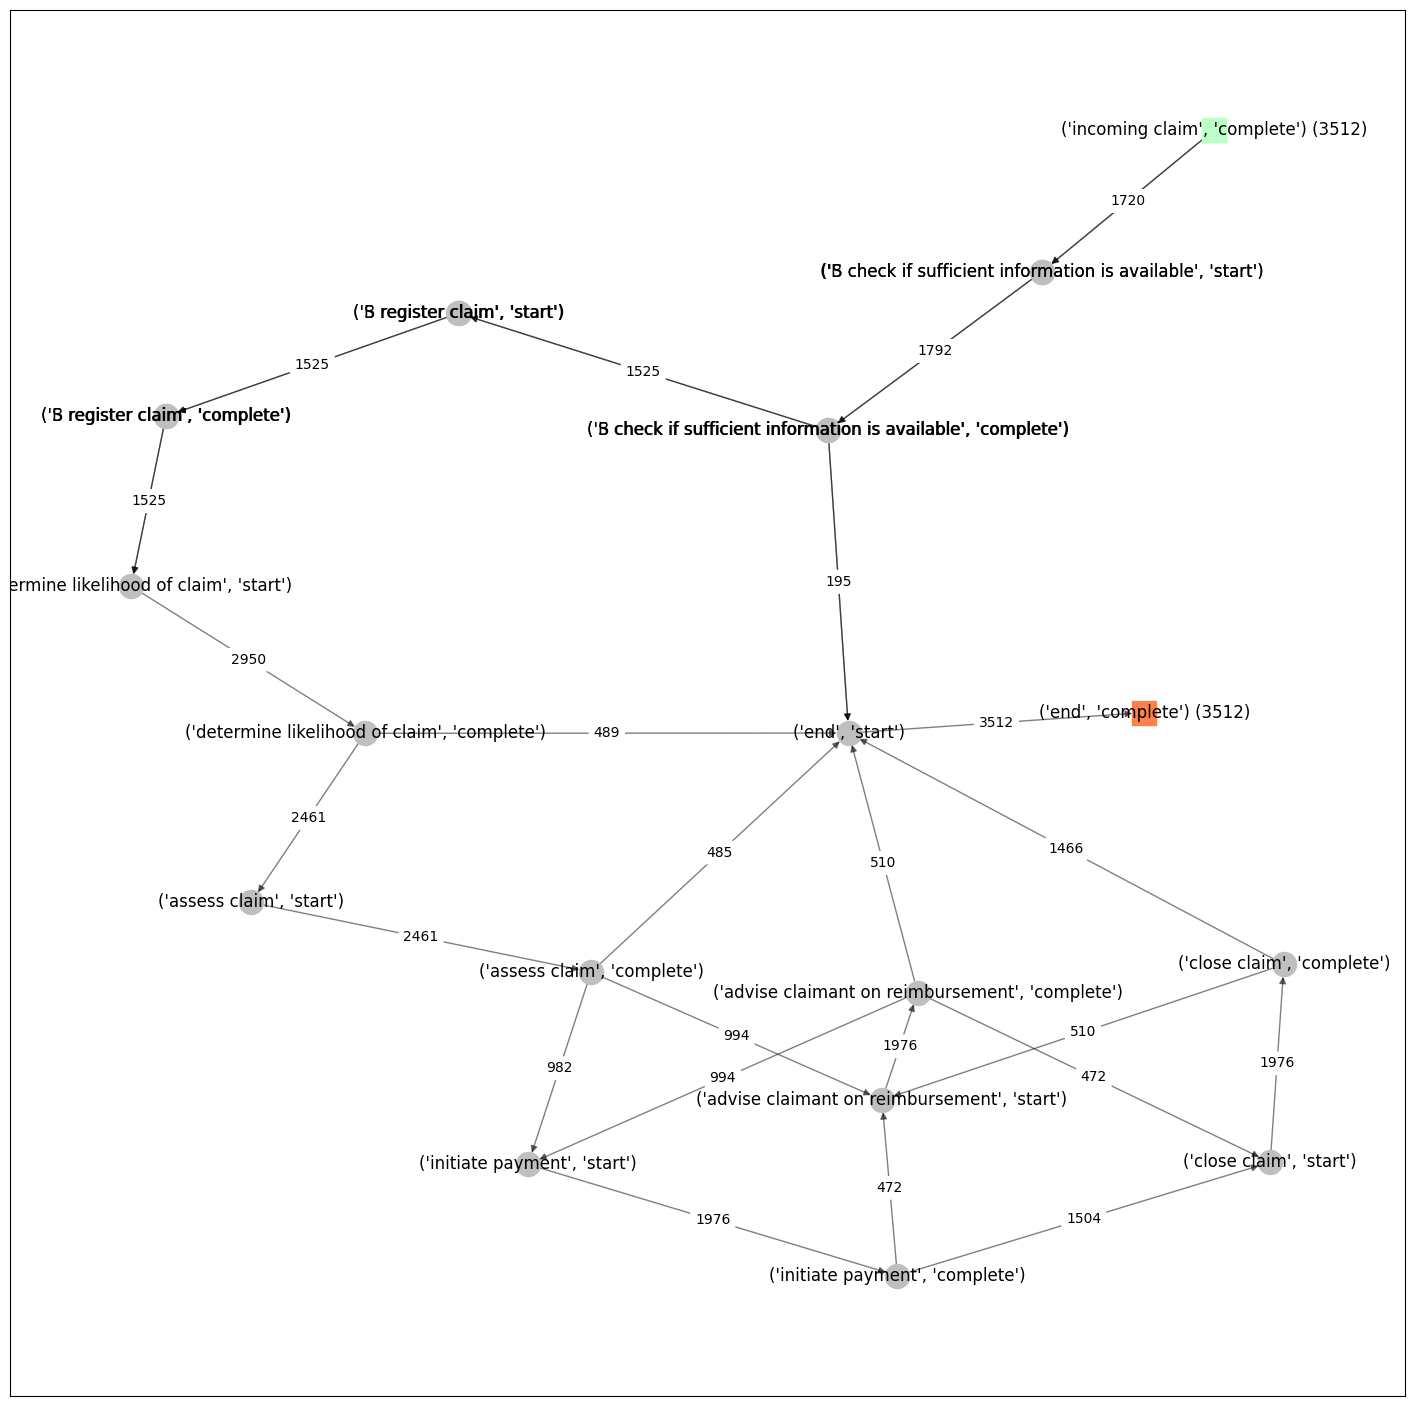

In [15]:
log_graph = generator.sequence_graph_

fig, ax = plt.subplots()
fig.set_size_inches(18, 18)
maxes.analyze_sequence.draw_nx_graph(log_graph, edge_label="frequency", ax=ax, pos=nx.kamada_kawai_layout(log_graph))

(siuo atveju, grafo atvaizdavimo algoritmas klaidingai sudejo kai kurius taskus i viena vieta)

pabandykime sugeneruoti sekas:

In [16]:
def display_sample_sequence():
    sequence = random_weighted_traverse(
        log_graph,
        min_steps=4,
        max_steps=10,
        weight_feature_name="frequency"
    )
    display(pd.DataFrame(sequence, columns=["concept:name", "lifecycle:transition"]))

display_sample_sequence()
display_sample_sequence()
display_sample_sequence()
display_sample_sequence()

,concept:name,lifecycle:transition
0,incoming claim,complete
1,B check if sufficient information is available,start
2,B check if sufficient information is available,complete
3,B register claim,start
4,B register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


,concept:name,lifecycle:transition
0,incoming claim,complete
1,S check if sufficient information is available,start
2,S check if sufficient information is available,complete
3,S register claim,start
4,S register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


,concept:name,lifecycle:transition
0,incoming claim,complete
1,S check if sufficient information is available,start
2,S check if sufficient information is available,complete
3,S register claim,start
4,S register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


,concept:name,lifecycle:transition
0,incoming claim,complete
1,S check if sufficient information is available,start
2,S check if sufficient information is available,complete
3,S register claim,start
4,S register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


Kaip matome, sugeneruotos sekos yra labai panasios i originalias sekas.

Kitame notebook'o lange generuojamas pavyzdinis trace'as, kuris bus nagrinejamas kituose zingsniuose.

In [17]:
from maxes.xes_loader2 import XesEvent, XesTrace

generated_trace = XesTrace()
generated_events_sequence = random_weighted_traverse(
    log_graph,
    min_steps=4,
    max_steps=10,
    weight_feature_name="frequency"
)

for event_sequence_item in generated_events_sequence:
    event = XesEvent()
    generated_trace.events.append(event)

    # concept:name and lifecycle:transition
    concept_name, lifecycle_transition = event_sequence_item
    event.attributes["concept:name"] = concept_name
    event.attributes["lifecycle:transition"] = lifecycle_transition

generated_trace.df
generated_trace.clear_cache()
generated_trace.df

,concept:name,lifecycle:transition
0,incoming claim,complete
1,S check if sufficient information is available,start
2,S check if sufficient information is available,complete
3,S register claim,start
4,S register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


# 2. "time:timestamp" atributo generavimas

daroma per du zingsnius:

  1. pirmo ivykio laikas (proceso pradzia)

  2. kitu ivykiu trukmes

## 2.1.

Nubraizykime visu trace'u pradziu laiku histograma:

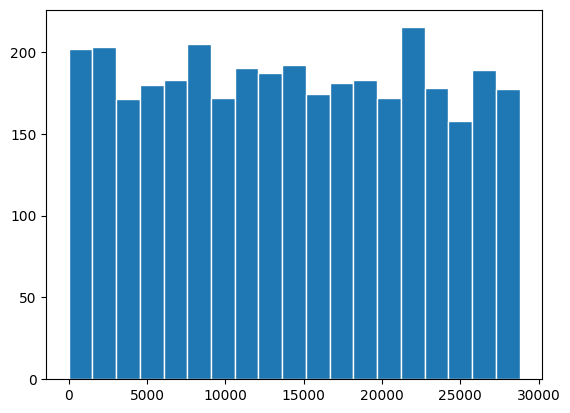

In [18]:
trace_beginning_timestamps_ = [trace.events[0].time_timestamp for trace in log.traces]
data = [date.timestamp() for date in trace_beginning_timestamps_]

bins = np.linspace(0, max(data), 20)
plt.hist(data, bins, edgecolor='white');

Is turimu duomenu imanoma gauti tikimybine funkcija, kad generuoti ivykiu laikus

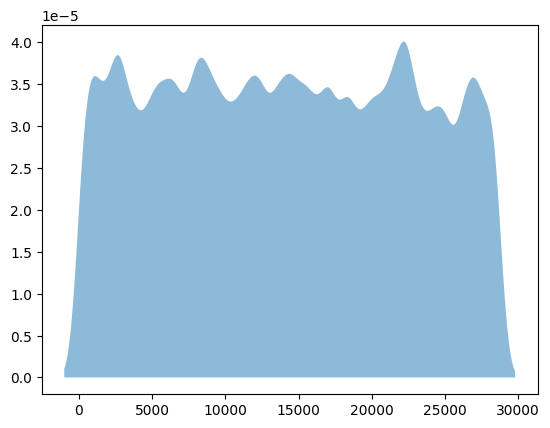

In [20]:
from sklearn.neighbors import KernelDensity

trace_beginning_timestamps_ = [trace.events[0].time_timestamp for trace in log.traces]

# data_1d = [date.hour for date in trace_beginning_timestamps_]
data_1d = [date.timestamp() for date in trace_beginning_timestamps_]
start, end = min(data_1d), max(data_1d)
x = np.linspace(start - 1000, end + 1000, 1000)

data_2d = [[date] for date in data_1d]
kde = KernelDensity(bandwidth=500).fit(data_2d)
y = kde.score_samples(x[:, None])

plt.fill_between(x, np.exp(y), alpha=0.5)

In [23]:
import datetime

generated_timestamps = kde.sample(10)
generated_datetimes = [datetime.datetime.fromtimestamp(item[0], tz=datetime.timezone.utc) for item in generated_timestamps]
pd.Series(generated_datetimes)

0   1970-01-01 04:24:17.294857+00:00
1   1970-01-01 02:29:54.836538+00:00
2   1970-01-01 01:56:52.075524+00:00
3   1970-01-01 06:39:13.494530+00:00
4   1970-01-01 04:52:12.458355+00:00
5   1970-01-01 01:08:37.808414+00:00
6   1970-01-01 04:59:08.047094+00:00
7   1970-01-01 01:33:43.210593+00:00
8   1970-01-01 01:19:19.534497+00:00
9   1970-01-01 06:07:09.223820+00:00
dtype: datetime64[ns, UTC]

## 2.2.

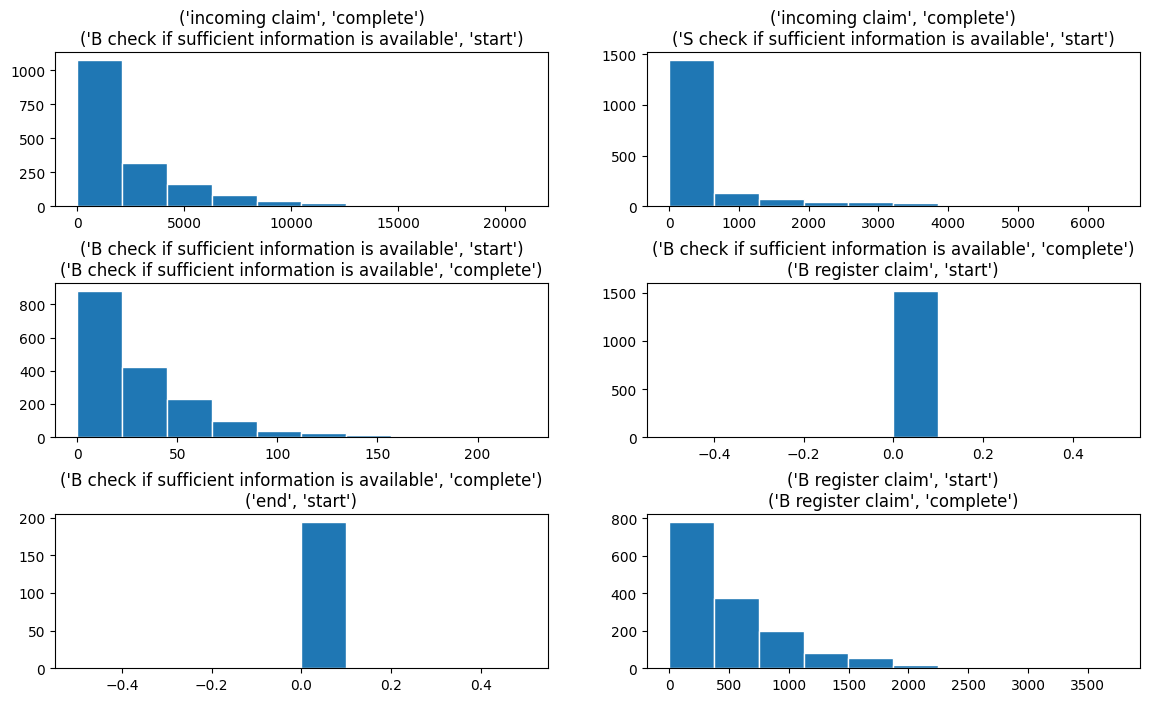

In [25]:
edges = list(generator.sequence_graph_.edges())

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    transition_durations = generator.sequence_graph_.edges[edge]["transition_durations"]
    seconds = [duration.seconds for duration in transition_durations]

    # seconds_series = pd.Series(seconds)
    # seconds_series.describe()

    ax.hist(seconds, edgecolor='white')

    first, second = edge
    ax.set_title(f"{first}\n{second}")

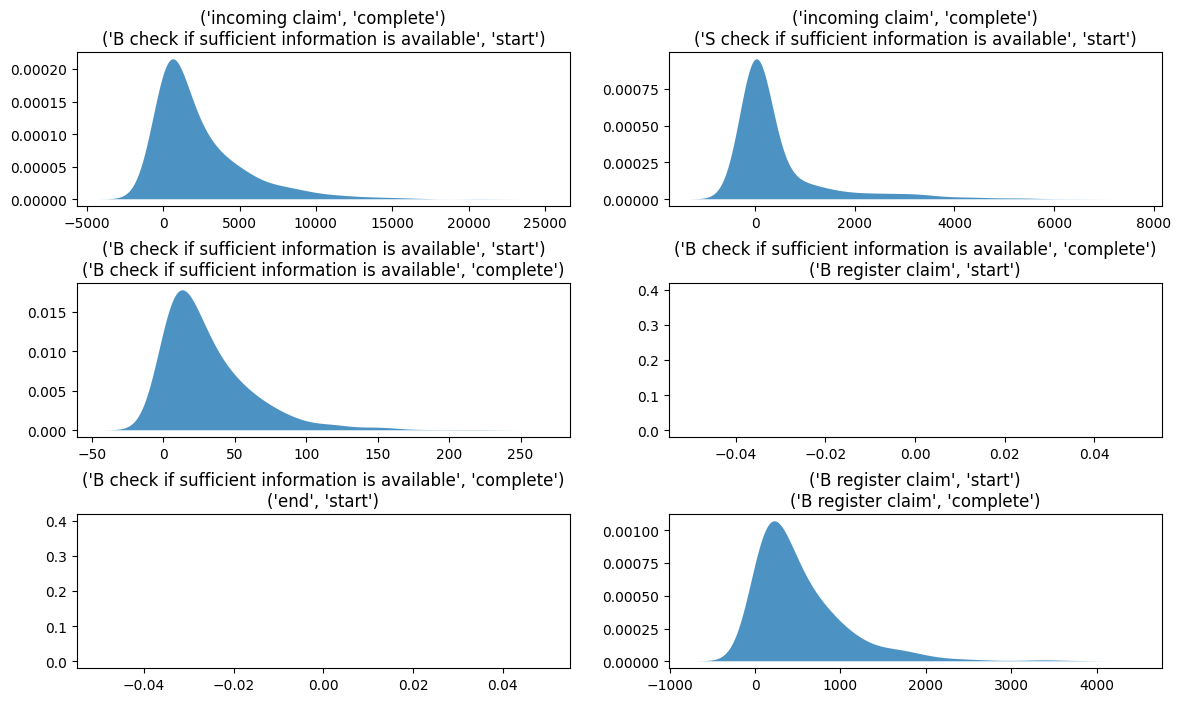

In [26]:
def draw_kde_for_transition(transition_name: str, ax, alpha=0.8):
    model = generator.sequence_graph_.edges[transition_name]["duration_generator"]

    transition_durations = generator.sequence_graph_.edges[edge]["transition_durations"]
    seconds = [duration.seconds for duration in transition_durations]
    start, end = min(seconds), max(seconds)
    interval_length = end - start
    interval_expansion = interval_length * 0.2

    x = np.linspace(start - interval_expansion, end + interval_expansion, 1000)

    y = np.exp(model.kde_.score_samples(x[:, None]))

    ax.fill_between(x, y, alpha=alpha);

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    draw_kde_for_transition(edge, ax=ax, alpha=0.8)
    first, second = edge
    ax.set_title(f"{first}\n{second}")

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 8)

for edge in edges[:10]:
    draw_kde_for_transition(edge, ax=ax, alpha=0.2)

# ax.set_xlim([-3000, 20000])
# ax.set_ylim([0, 0.002])

ax.set_xlim([-5000, 50000])
ax.set_yscale('log')
ax.set_ylim([0, 0.05])

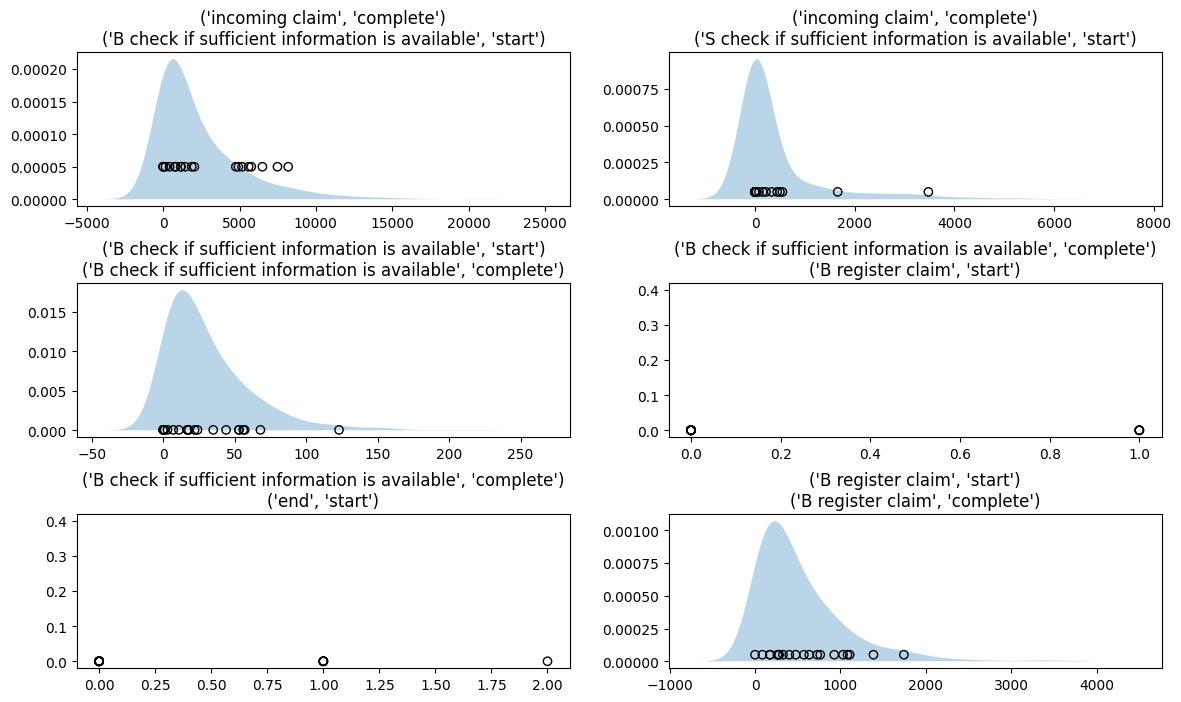

In [28]:
def draw_kde_transition_samples(transition_name: str, ax):
    model = generator.sequence_graph_.edges[transition_name]["duration_generator"]

    samples_x = [sample.seconds for sample in model.sample(n_samples=20)]
    samples_y = [0.00005 for sample in samples_x]

    ax.scatter(samples_x, samples_y, facecolors='none', edgecolors='black')

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    draw_kde_for_transition(edge, ax=ax, alpha=0.3)
    draw_kde_transition_samples(edge, ax=ax)
    first, second = edge
    ax.set_title(f"{first}\n{second}")

## 2.1 + 2.2

In [103]:
import itertools

generated_trace.events[0].attributes["time:timestamp"] = generator.trace_beginning_timestamp_generator_.sample()[0]

for current_event, next_event in itertools.pairwise(generated_trace.events):
    edge = (
        XesGenerator1._get_sequence_graph_node_key(current_event),
        XesGenerator1._get_sequence_graph_node_key(next_event),
    )
    duration_generator = generator.sequence_graph_.edges[edge]["duration_generator"]
    sample_duration = duration_generator.sample()[0]
    next_event.attributes["time:timestamp"] = current_event.time_timestamp + sample_duration

generated_trace.clear_cache()
generated_trace.df

,concept:name,lifecycle:transition,time:timestamp
0,incoming claim,complete,1970-01-01 05:26:31.337887+00:00
1,B check if sufficient information is available,start,1970-01-01 05:27:40.813757+00:00
2,B check if sufficient information is available,complete,1970-01-01 05:28:37.655101+00:00
3,B register claim,start,1970-01-01 05:28:37.655101+00:00
4,B register claim,complete,1970-01-01 05:46:55.315561+00:00
5,determine likelihood of claim,start,1970-01-01 06:48:31.454108+00:00
6,determine likelihood of claim,complete,1970-01-01 06:48:53.375571+00:00
7,end,start,1970-01-01 06:48:53.375571+00:00
8,end,complete,1970-01-01 06:48:54.328176+00:00


# 3. kitu atributu generavimas

atkreipkime demesi i kitu atributu priklausomybe nuo pagrindiniu:

In [110]:
log.traces[0].df[["concept:name", "org:resource"]]

,concept:name,org:resource
0,incoming claim,customer
1,B check if sufficient information is available,Call Centre Agent Brisbane
2,B check if sufficient information is available,Call Centre Agent Brisbane
3,B register claim,Call Centre Agent Brisbane
4,B register claim,Call Centre Agent Brisbane
5,determine likelihood of claim,Claims handler
6,determine likelihood of claim,Claims handler
7,end,Claims handler
8,end,Claims handler


In [129]:
from sklearn.preprocessing import OneHotEncoder

input_encoder = OneHotEncoder()
X_series = log.df["concept:name"]
X_np = np.array(X_series).reshape(-1, 1)
X = input_encoder.fit_transform(X_np)

X.toarray()[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [130]:
output_encoder = OneHotEncoder()
y_series = log.df["org:resource"]
y_np = np.array(y_series).reshape(-1, 1)
y = output_encoder.fit_transform(y_np)

y.toarray()[:5]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [131]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.fit(X, y)

MLPClassifier()

In [139]:
generated_concept_name = np.array(generated_trace.df["concept:name"]).reshape(-1, 1)
X = input_encoder.transform(generated_concept_name)
y_pred = model.predict(X)
generated_org_resource = output_encoder.inverse_transform(y_pred).ravel()

generated_trace.df["org:resource"] = generated_org_resource

generated_trace.df

,concept:name,lifecycle:transition,time:timestamp,org:resource
0,incoming claim,complete,1970-01-01 05:26:31.337887+00:00,customer
1,B check if sufficient information is available,start,1970-01-01 05:27:40.813757+00:00,Call Centre Agent Brisbane
2,B check if sufficient information is available,complete,1970-01-01 05:28:37.655101+00:00,Call Centre Agent Brisbane
3,B register claim,start,1970-01-01 05:28:37.655101+00:00,Call Centre Agent Brisbane
4,B register claim,complete,1970-01-01 05:46:55.315561+00:00,Call Centre Agent Brisbane
5,determine likelihood of claim,start,1970-01-01 06:48:31.454108+00:00,Claims handler
6,determine likelihood of claim,complete,1970-01-01 06:48:53.375571+00:00,Claims handler
7,end,start,1970-01-01 06:48:53.375571+00:00,Claims handler
8,end,complete,1970-01-01 06:48:54.328176+00:00,Claims handler


# 4. (bonus) everything together

In [144]:
%autoreload
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from maxes.generators.xes_generator.xes_generator3 import XesGenerator3, XesAttributeModelPredictor

model_prototype = Pipeline(steps=[
    ("column selector", ColumnTransformer([
        ("concept_name", OneHotEncoder(), ["concept:name"]),
        ("lifecycle_transition", OneHotEncoder(), ["lifecycle:transition"])
    ])),
    ("classifier", MLPClassifier())
])

final_generator = XesGenerator3(
    attributes_models=[
        XesAttributeModelPredictor(
            attribute="org:resource",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="location",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="call centre",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        ),

        XesAttributeModelPredictor(
            attribute="outcome",
            dependent_attributes=["concept:name", "lifecycle:transition"],
            model=clone(model_prototype),
            output_transformer=OneHotEncoder()
        )
    ],
    traces_count=1
)
final_generator.fit(log)

In [145]:
final_generated_log = final_generator.generate()

In [147]:
final_generated_log._update_df()
final_generated_log.df

,concept:name,lifecycle:transition,time:timestamp,org:resource,call centre,location,outcome
0,incoming claim,complete,1970-01-01 06:09:22.023586+00:00,customer,Sydney,NaN,NaN
1,S check if sufficient information is available,start,1970-01-01 06:09:22.674022+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN
2,S check if sufficient information is available,complete,1970-01-01 06:09:52.668151+00:00,Call Centre Agent Sydney,NaN,Sydney,NaN
3,S register claim,start,1970-01-01 06:09:51.974692+00:00,Call Centre Agent Sydney,NaN,NaN,NaN
4,S register claim,complete,1970-01-01 06:12:51.376411+00:00,Call Centre Agent Sydney,NaN,NaN,NaN
5,determine likelihood of claim,start,1970-01-01 08:32:46.552581+00:00,Claims handler,NaN,NaN,NaN
6,determine likelihood of claim,complete,1970-01-01 08:33:16.986242+00:00,Claims handler,NaN,NaN,NaN
7,end,start,1970-01-01 08:33:18.945422+00:00,Claims handler,NaN,NaN,processed
8,end,complete,1970-01-01 08:33:19.236025+00:00,Claims handler,NaN,NaN,processed
